# Mesh Variables


Mesh variables are used to encode spatial data across the mesh. Underworld mesh variables assign data for each node of the mesh, so for example you might assign a temperature value at each mesh node. Mesh variables also leverage the mesh element shape functions to form interpolations within elements, allowing our discrete datasets to have continuous analogues formed. 

Mesh variables may be used for any number of purposes when constructing models, but most importantly they form the unknowns for the finite element numerical systems you will be solving. 


#### Overview:
1. Creating a mesh variable.
1. Setting values on a mesh variables.
1. Gradients of mesh variable fields.
1. Loading and saving mesh variable data.

**Keywords:** mesh variables, finite elements, load, save, initial conditions

## Creating a MeshVariable

We create a mesh variable by using the mesh's `add_variable()` method, and specifying the `nodeDofCount` (node degree of freedom count).

With `nodeDofCount=1` a scalar variable is defined at each node of the mesh eg, temperature field.

In [10]:
import underworld as uw
import glucifer
import math
# we need a mesh
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (4, 4), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (2., 1.) )
# now create our mesh variable
temperatureField = mesh.add_variable( nodeDofCount=1 )

## Setting values on the MeshVariable

We may now set values on the mesh variable. As you will find with most Underworld data carrying objects, you will access the data directly via the `data` attribute. Our data is stored there as a numpy array, and you may therefore accessed or modified it using standard Numpy operations.

Let's initialise the temperature variable with a function based on its spatial coordinates
\\[
T = 100\exp(1-z)
\\]

We will walk over the mesh vertex data to access coordinate information. As the temperature field data is by design a 1-1 map to the vertex data, we know the index of the mesh vertex will be the index of the associated temperature datum. Note that the Python *built-in* `enumerate()` acts to return **both** the index of a piece of data in a list (or array), and the data itself. 


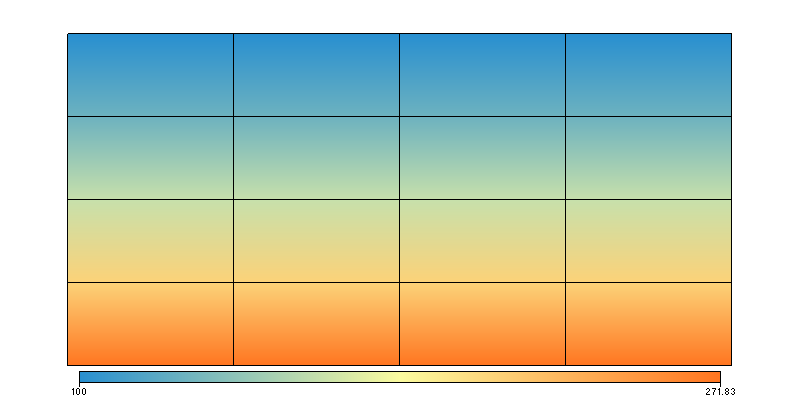

In [33]:
pi = math.pi
for index, coord in enumerate(mesh.data):
    temperatureField.data[index] = 100.*math.exp(1.-coord[1])

# vis results    
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.Surface(mesh, temperatureField) )
fig.append( glucifer.objects.Mesh(mesh) )
fig.show()

To describe for example a velocity, a vector mesh variable is required. We set `nodeDofCount=2` accordingly, and initialise to:

$$
    \mathbf{v} = \left( z_0 - z, x - x_0 \right)
$$


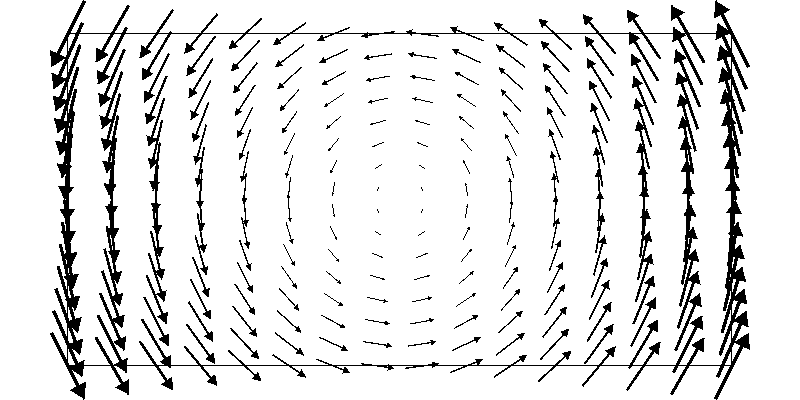

In [34]:
velocityField = mesh.add_variable( nodeDofCount=2 )

coordmid = (1., 0.5)
for index, coord in enumerate(mesh.data):
    vx = coordmid[1] - coord[1]
    vz = coord[0]    - coordmid[0]
    velocityField.data[index] = (vx, vz)

# visualise both the velocity and temperature
fig = glucifer.Figure(figsize=(800,400))
fig.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.2, arrowHead=0.2) )
fig.show()

## Mesh variables gradients

Mesh variable gradients are calculated according to:

$$
    \nabla A(\mathbf{r}) = A_i\nabla\Phi_i(\mathbf{r})
$$
Note that gradients derived in this way are not generally continuous across element boundaries. Note that we access the different gradient components via the square bracket operator, with ordering:
$$
[ \frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}, \frac{\partial T}{\partial z} ]
$$
or for a vector field:
$$
    [ \frac{\partial v_x}{\partial x}, \frac{\partial v_x}{\partial y}, \frac{\partial v_x}{\partial z},
      \frac{\partial v_y}{\partial x}, \frac{\partial v_y}{\partial y}, \frac{\partial v_y}{\partial z},
      \frac{\partial v_z}{\partial x}, \frac{\partial v_z}{\partial y}, \frac{\partial v_z}{\partial z} ]
$$


The gradient of the field is accessible via the ``fn_gradient`` attribute on the mesh variable.




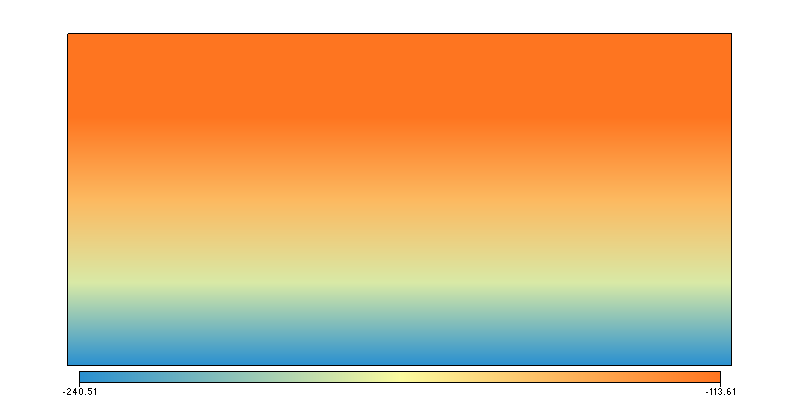

In [37]:
gradfield = temperatureField.fn_gradient[1]
figGrad = glucifer.Figure(figsize=(800,400))
figGrad.append( glucifer.objects.Surface(mesh, gradfield) )
figGrad.show()

## Loading and saving variables

In this example we will use the set values for the temperature field, save them to file, reset them, and then recover the original data by loading from the file. You will use the usual `save()` and `load()` methods on the mesh variable. 

Note that as for the mesh, Underworld uses HDF5 for writing data to disk.

In [41]:
temperatureField.save('MeshVariableSaveExample.h5')
# now create a new variable to load this data into
loadedVariable = mesh.add_variable(1)
# init to zero to be sure
loadedVariable.data[:] = 0.
# now load the data into the new variable
loadedVariable.load('MeshVariableSaveExample.h5')
# sanity check via Numpy array comparison
import numpy as np
result = np.allclose(temperatureField.data, loadedVariable.data)

# if this didn't work correctly, let's raise an error to alert the user.
if result == False:
    raise RuntimeError("The loaded variable does not correspond to the saved variable.")

    
# remove the saved file as it is no longer required. 
if uw.rank()==0:
    import os;
    os.remove("MeshVariableSaveExample.h5")